Import of the differents libraries needed

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Declaration of the state equation parameters and the non linear 

In [6]:
#A = np.array([[0.9512, 0],[0.0476, 0.9512]])
B = np.array([0.0975, 0.0024])
C = np.array([0,1])
G = 1

alpha1 = 1; alpha2 = 1; beta = 1
def f(x,u):
    return np.array([-alpha1*np.sqrt(x[0]) + beta*u,
                    alpha1*np.sqrt(x[0]) - beta*np.sqrt(x[1])])

Import of the data

In [114]:
with open('Data_nonlinear_case/True_state_x1_nonlinear_case.txt', "r") as f:
    f.readline()
    True_state_x1 = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))        
with open('Data_nonlinear_case/True_state_x2_nonlinear_case.txt', "r") as f:
    f.readline()
    True_state_x2 = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))   
with open('Data_nonlinear_case/Input_nonlinear_case.txt', "r") as f:
    f.readline()
    u = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))  
with open('Data_nonlinear_case/Measured_output_nonlinear_case.txt', "r") as f:
    f.readline()
    y = np.array(list(float(f.readline().split(" ")[0]) for i in range(1000)))   

Defining noises w(k) and v(k). We don't compute them because they will change at each iteration.

In [115]:
mu_w = np.array([0,0])
Q = 0.001*np.array([[9.506,0.234],[0.234,9.512]])
#w = np.random.multivariate_normal(mu_w, Q)
mu_v = 0
R = 0.0125
#v = np.random.normal(mu_v, R, 1000)

Defining some vectors

In [116]:
N = 20 #number of elements in the initial ensemble

mu_x_0 = np.array([5,5])
P_0 = np.array([[1,0],[0,1]])

x_hat = np.zeros((1000,N,2))
x_hat[0,:,:] = np.random.multivariate_normal(mu_x_0,P_0,N)

#x_tilde = np.zeros((1000,N,2))
#x_tilde[0,:,:] = np.random.multivariate_normal(mu_x_0,P_0,N)

y_tilde = np.zeros((1000,N))
y_tilde[0,:] = [np.dot(C,x_hat[0,l,:])+np.random.normal(mu_v, R) for l in range(N)]

Pk = np.zeros((1000,2,2))
Pk[0] = P_0

muk = np.zeros((1000,2))
muk[0] = mu_x_0

Compute of the forecast step, x(k|k-1) and the update step x(k|k)

In [117]:
for k in range(1,1000):
    for i in range(N):
        x_hat[k,i,:] = np.dot(A,x_hat[k-1,i,:]) + B * u[k] + np.random.multivariate_normal(mu_w, Q)
    Pk[k] = np.cov(x_hat[k,:,:].T)
    for i in range(N):
        y_tilde[k,i] = np.dot(C,x_hat[k,i,:]) + np.random.normal(mu_v, R)
        CPCTR = np.dot(C,np.dot(Pk[k],C.transpose()))+R #toujours un scalaire
        Kk = np.dot(Pk[k],C.transpose())/CPCTR
        x_hat[k,i,:] = x_hat[k,i,:] + Kk * (y[k] - y_tilde[k,i])
    muk[k] = np.mean(x_hat[k], axis=0)

Compute the confidence intervals

In [118]:
upper_x1 = np.array([(1.96 * Pk[w,0,0]**0.5)+muk[w,0] for w in range(1000)])
lower_x1 = np.array([-1.96 * Pk[w,0,0]**0.5+muk[w,0] for w in range(1000)])
upper_x2 = np.array([1.96 * Pk[w,1,1]**0.5+muk[w,1] for w in range(1000)])
lower_x2 = np.array([-1.96 * Pk[w,1,1]**0.5+muk[w,1] for w in range(1000)]) 

Compute the RMSD function

In [119]:
def RMSD(x,y):
    n = len(x)
    v = np.power(x-y,2)
    rmsd = np.zeros(n)
    for i in range(n):
        rmsd[i] = np.sqrt(np.sum(v[:i+1,:]) / (i+1))
    return rmsd
        
rmsd = RMSD(np.array([True_state_x1, True_state_x2]).T,muk)

Plot of the states, True values vs Filtered values with the confidence interval

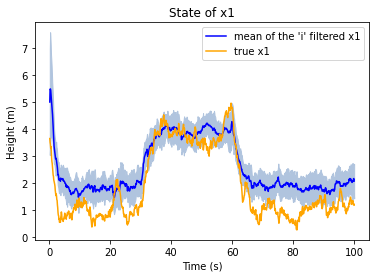

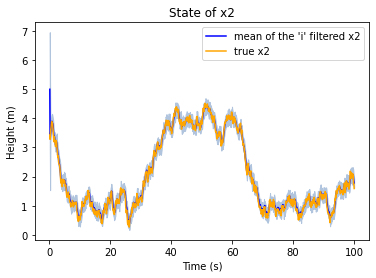

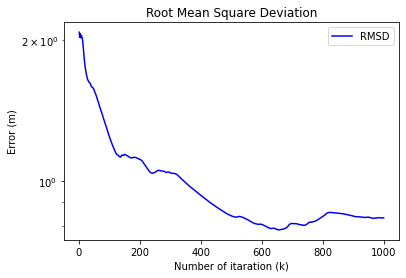

In [120]:
figure1 = plt.figure()
figure2 = plt.figure()
figure3 = plt.figure()
time = np.linspace(0.1,100,1000)
ax1 = figure1.add_subplot(1,1,1) #retourne un objet de type Axes
ax1.plot(time,muk[:,0], label= "mean of the 'i' filtered x1" , color='blue')
ax1.plot(time,True_state_x1, label= "true x1" , color='orange')
ax1.fill_between(time,upper_x1,lower_x1, color='lightsteelblue')
ax2 = figure2.add_subplot(1,1,1) #retourne un objet de type Axes
ax2.plot(time,muk[:,1], label= "mean of the 'i' filtered x2", color='blue' )
ax2.plot(time,True_state_x2, label= "true x2" , color='orange')
ax2.fill_between(time,upper_x2,lower_x2, color='lightsteelblue')
ax3 = figure3.add_subplot(1,1,1) #retourne un objet de type Axes
ax3.semilogy(time*10,rmsd, label= "RMSD" , color='blue')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_title("State of x1")
ax2.set_title("State of x2")
ax3.set_title("Root Mean Square Deviation")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Number of itaration (k)")
ax1.set_ylabel("Height (m)")
ax2.set_ylabel("Height (m)")
ax3.set_ylabel("Error (m)")
plt.show()
#figure1.savefig('Statex1_EnKF_%d_lin.png'%(N))
#figure2.savefig('Statex2_EnKF_%d_lin.png'%(N))
#figure3.savefig('RMSD_EnKF_%d_lin.png'%(N))